In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# mlQTLs: algorithm for QTLs mapping (and feature selection??)

I want to develop an ensemble L1norm approach for QTLs mapping, but it can be used also for feature selection on regression problems (maybe).

I took the idea (especially for classification tasks) from [this
manuscript](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5260053/)

### QTL mapping (main functionality)
You should use Rqtl for simulating crosses

In [4]:
#import rpy2
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


Create cell with R code **BC dominant QTLs**

## Develop pipeline
The next cell hs the algorithm

Use of LassoCV

In [5]:
# main function
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils import resample
from sklearn.datasets import make_regression
from sklearn.svm import LinearSVR
from sklearn.linear_model import LassoCV
from scipy import stats

def optimize_weights(X, y, cv):
    alphas = 1/(X.shape[0]*np.logspace(-5, 4, 10))
    model = LassoCV(alphas=alphas, cv = cv, random_state=42, 
                    precompute=True, positive=True, n_jobs=-1)
    model.fit(X,y)
    return model.coef_
    
def mlQTLs_analysis(X, y, n_estimators=500,
                    max_samples = 0.8, cv = 5, random_state=42):
    '''main function that will call the other functions'''
    all_w = []
    for i in range(n_estimators):
        # loop over the number of estimators
        X_res, y_res = resample(X, y,
                                n_samples=int(np.ceil(X.shape[0]*max_samples)),
                                replace=True, random_state=i*random_state)
        w = optimize_weights(X_res, y_res, cv=cv)
        all_w.append(w)
    # now you will need to:
        #1) Calculate the stability score for each feature
        #2) Sum the scores
        #3) for optimization purpose I will return the full  coeff_array
    all_w = np.array(all_w)
    w= np.sum(all_w, axis=0)
    bin_matrix = np.where(all_w>0, 1, 0)
    s_scores = np.sum(bin_matrix, axis=0)
    return w, s_scores

# Single dominant QTL

**Simulation**

    Backcross

    No. individuals:    250 

    No. phenotypes:     1 
    Percent phenotyped: 100 

    No. chromosomes:    5 
        Autosomes:      1 2 3 4 5 

    Total markers:      585 
    No. markers:        130 95 100 120 140 
    Percent genotyped:  100 
    Genotypes (%):      AA:50.6  AB:49.4 


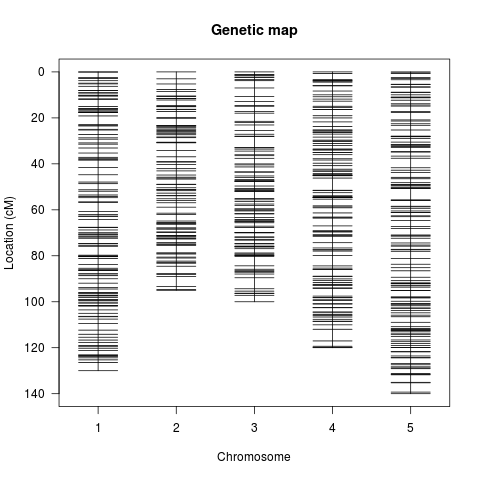

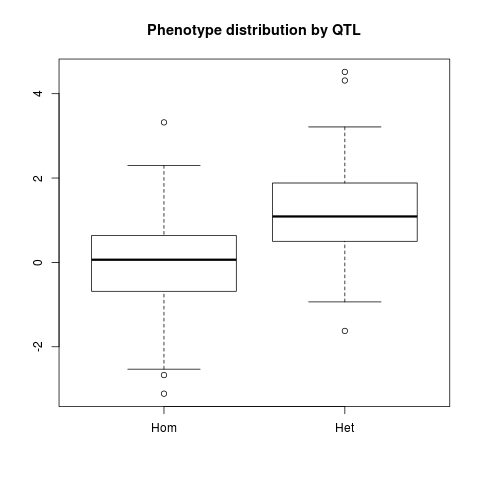

In [6]:
%%R
library(qtl)
L=c(130, 95, 100, 120, 140)
set.seed(121)
mapD=sim.map(L, L, eq.spacing=F, include.x=F)
plot(mapD)
bc_model = rbind(c(3, 25, 1))
BC_cross = sim.cross(mapD, n.ind=250, type='bc', model = bc_model)
p1 = subset(BC_cross$pheno[,1], BC_cross$qtlgeno[,1]==1)
p2 = subset(BC_cross$pheno[,1], BC_cross$qtlgeno[,1]==2)
boxplot(p1, p2, names=c('Hom', 'Het'), main='Phenotype distribution by QTL')
print(summary(BC_cross))
write.cross(BC_cross, format='csv', filestem='BC_dominant_cross')

**Evaluation on RQTL**

 --Read the following data:
	 250  individuals
	 585  markers
	 1  phenotypes
 --Cross type: bc 
    Backcross

    No. individuals:    250 

    No. phenotypes:     1 
    Percent phenotyped: 100 

    No. chromosomes:    5 
        Autosomes:      1 2 3 4 5 

    Total markers:      585 
    No. markers:        130 95 100 120 140 
    Percent genotyped:  100 
    Genotypes (%):      AA:50.6  AB:49.4 
        chr        pos       lod
D1M1      1 0.00000000 0.2738433
D1M2      1 0.08463854 0.2738481
c1.loc1   1 1.00000000 0.3264282
c1.loc2   1 2.00000000 0.3848375
D1M3      1 2.62474556 0.4211742
D1M4      1 2.66862727 0.4211767
[1] "scanone"    "data.frame"
[1] "scanone"    "data.frame"
png 
  2 


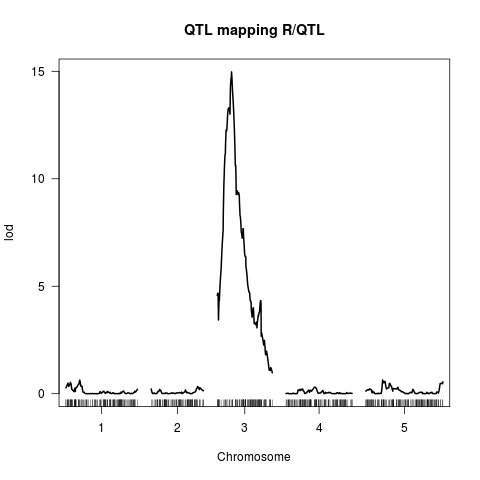

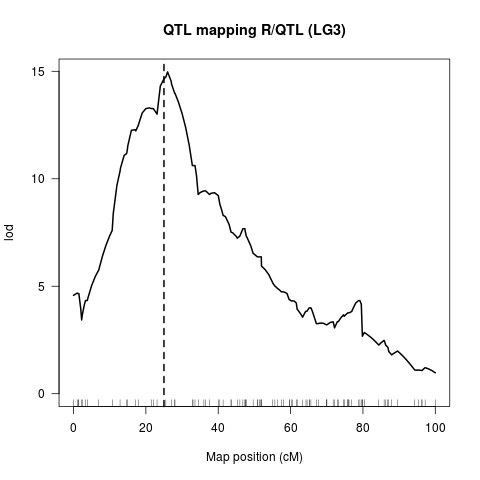

In [7]:
%%R

library(qtl)
data = read.cross('csv', file = 'BC_dominant_cross.csv', estimate.map=F, 
                  crosstype='bc')
print(summary(data))
data = calc.genoprob(data, step=1, error.prob=0.001)
#data=jittermap(data)
out.mr = scanone(data, method='em')
print(head(out.mr))

plot(out.mr, main='QTL mapping R/QTL')
plot(out.mr, chr=3, main='QTL mapping R/QTL (LG3)')
abline(v=25, lty=2, lwd=2)
print(class(out.mr))


pdf('Results_RQtls.pdf', width=8, height=4)
plot(out.mr, main='QTL mapping R/QTL')
plot(out.mr, chr=3, main='QTL mapping R/QTL (LG3)')
abline(v=25, lty=2, lwd=2)
print(class(out.mr))
dev.off()

## Evaluate pipeline

In [8]:
cross = pd.read_csv('BC_dominant_cross.csv', sep=',', header=0, skiprows=[1,2])
cross.head()

,phenotype,D1M1,D1M2,D1M3,D1M4,D1M5,D1M6,D1M7,D1M8,D1M9,...,D5M131,D5M132,D5M133,D5M134,D5M135,D5M136,D5M137,D5M138,D5M139,D5M140
0,0.921074,H,H,H,H,H,H,H,H,H,...,A,A,A,A,A,A,A,A,A,A
1,-1.043427,H,H,H,H,H,H,H,H,H,...,A,A,A,A,A,A,A,A,A,A
2,1.692309,A,A,A,A,A,A,A,A,A,...,H,H,H,H,H,H,H,H,H,H
3,0.161661,H,H,H,H,H,H,H,H,H,...,A,A,A,A,A,A,A,A,A,A
4,-0.763335,A,A,A,A,A,A,A,A,A,...,A,A,A,A,A,A,A,A,A,H


In [9]:
# prepare Y and drop
y = cross['phenotype']
cross = cross.drop('phenotype', axis=1)
cross.head()

,D1M1,D1M2,D1M3,D1M4,D1M5,D1M6,D1M7,D1M8,D1M9,D1M10,...,D5M131,D5M132,D5M133,D5M134,D5M135,D5M136,D5M137,D5M138,D5M139,D5M140
0,H,H,H,H,H,H,H,H,H,A,...,A,A,A,A,A,A,A,A,A,A
1,H,H,H,H,H,H,H,H,H,H,...,A,A,A,A,A,A,A,A,A,A
2,A,A,A,A,A,A,A,A,A,A,...,H,H,H,H,H,H,H,H,H,H
3,H,H,H,H,H,H,H,H,H,H,...,A,A,A,A,A,A,A,A,A,A
4,A,A,A,A,A,A,A,A,A,A,...,A,A,A,A,A,A,A,A,A,H


In [10]:
#prepare_array
d = {'A':0, 'H':1}
cross_numeric = cross.replace(to_replace=d)
cross_numeric.head()

,D1M1,D1M2,D1M3,D1M4,D1M5,D1M6,D1M7,D1M8,D1M9,D1M10,...,D5M131,D5M132,D5M133,D5M134,D5M135,D5M136,D5M137,D5M138,D5M139,D5M140
0,1,1,1,1,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
3,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


LASSOCV

In [11]:
from sklearn.model_selection import train_test_split
X = cross_numeric.values
y = y.values

weights, scores = mlQTLs_analysis(X, y, n_estimators=10)

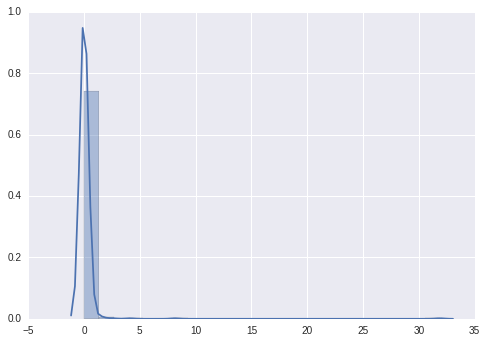

In [12]:
vals =weights*scores
sns.distplot(vals)
plt.show()

In [13]:
print(np.percentile(vals, q=[50, 75, 90, 95, 99]))
q = np.percentile(vals, q=99)
np.median(vals)

[ 0.          0.          0.03688558  0.14233335  1.3781718 ]


0.0

In [14]:
new_frame = pd.DataFrame({'markers_ID': cross_numeric.columns, 'Vals' :vals})
new_frame.head()

,Vals,markers_ID
0,0.0,D1M1
1,0.0,D1M2
2,0.0,D1M3
3,0.0,D1M4
4,0.0,D1M5


In [15]:
new_frame.sort_values(by='Vals', ascending=False).head()

,Vals,markers_ID
243,31.905589,D3M19
244,8.138196,D3M20
245,4.084490,D3M21
31,2.580812,D1M32
237,1.665740,D3M13


## Final resolution

**Use np.sum for the scores.
You can use np.exp2(w+s) for the score and identify the most significant marker**

This option works kind of well with small effects single QTLs (ration 0.6 you can still identify good markers)
It would be interesting to evaluate the number of iterations depending on the QTL effect.

BTW you should check the LassoCV coefficient distribution as well.

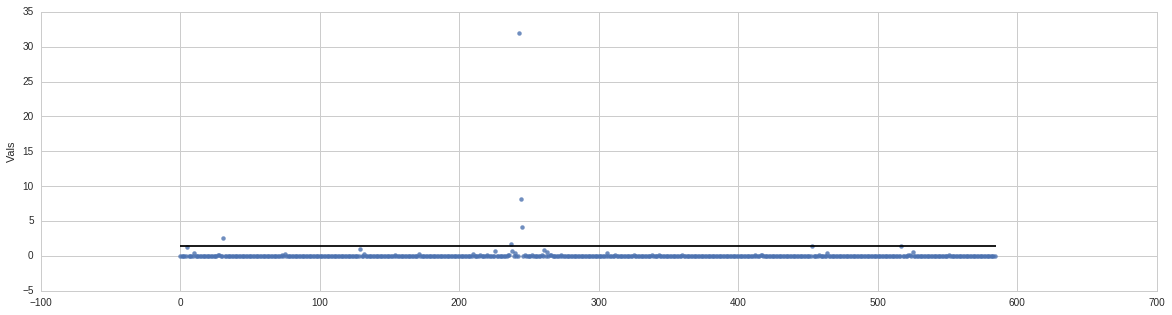

In [16]:
sns.set_style('whitegrid')
plt.figure(figsize=(20,5))
sns.regplot(x=np.array(np.arange(len(vals))), y=new_frame['Vals'], scatter=True, 
            fit_reg=False)#, lowess=True)
plt.hlines(q, xmin=0, xmax=len(vals))
plt.show()

In [17]:
cross2 = pd.read_csv('BC_dominant_cross.csv', sep=',', header=0)#, skiprows=[1])
cross2.head()

,phenotype,D1M1,D1M2,D1M3,D1M4,D1M5,D1M6,D1M7,D1M8,D1M9,...,D5M131,D5M132,D5M133,D5M134,D5M135,D5M136,D5M137,D5M138,D5M139,D5M140
0,NaN,1,1,1,1,1,1,1,1,1,...,5,5,5,5,5,5,5,5,5,5
1,NaN,0,0.0846385443583131,2.62474556220695,2.66862726770341,2.67997213173658,3.83242485346273,4.89041295368224,5.21914853015915,6.26371550373733,...,128.305828138255,128.777501834556,129.11530977115,131.227517067455,131.693511707708,131.784859029576,135.04305947572,135.276953992434,139.30372371804,140
2,0.921074,H,H,H,H,H,H,H,H,H,...,A,A,A,A,A,A,A,A,A,A
3,-1.043427,H,H,H,H,H,H,H,H,H,...,A,A,A,A,A,A,A,A,A,A
4,1.692309,A,A,A,A,A,A,A,A,A,...,H,H,H,H,H,H,H,H,H,H


In [18]:
sign_markers=new_frame[new_frame['Vals']>=q]['markers_ID'].values
print(sign_markers)
cross2[sign_markers].head()

['D1M32' 'D3M13' 'D3M19' 'D3M20' 'D3M21' 'D5M73']


,D1M32,D3M13,D3M19,D3M20,D3M21,D5M73
0,1,3,3,3,3,5
1,24.9669558298774,14.9261589627713,25.5257339915261,27.1074198419228,27.970555680804,74.4269374618307
2,A,H,H,H,H,A
3,H,A,A,A,A,H
4,A,H,H,H,H,H


In [19]:
chrom_ID = cross2.iloc[0, 1:]
cM = cross2.iloc[1, 1:]
final_res = pd.DataFrame({'CHR':chrom_ID, 'BP':cM, 'P':vals}, columns=['CHR', 'BP', 'P'])
final_res.head()

,CHR,BP,P
D1M1,1,0,0.0
D1M2,1,0.0846385443583131,0.0
D1M3,1,2.62474556220695,0.0
D1M4,1,2.66862726770341,0.0
D1M5,1,2.67997213173658,0.0


In [20]:
%Rpush final_res

png 
  2 


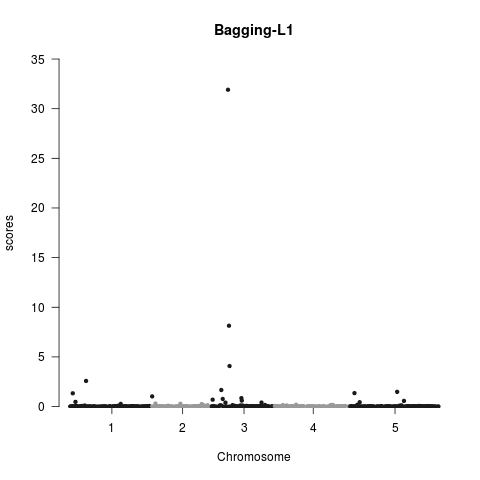

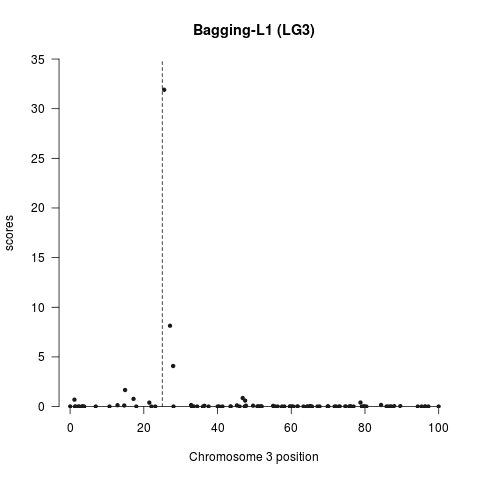

In [22]:
%%R

library(qqman)
final_res$CHR=as.numeric(final_res$CHR)
final_res$BP=as.numeric(final_res$BP)
class(final_res$P)
manhattan(final_res, logp=F, suggestiveline=F, genomewideline=F, ylab='scores', main='Bagging-L1',
         ylim=c(0,35))

manhattan(subset(final_res, final_res$CHR==3), logp=F, suggestiveline=F, genomewideline=F, 
          ylab='scores', main='Bagging-L1 (LG3)', ylim=c(0,35))
abline(v=25, lty=2)


pdf('Results_BagL1.pdf', width=8, height=4)
manhattan(final_res, logp=F, suggestiveline=F, genomewideline=F, ylab='scores', main='Bagging-L1',
         ylim=c(0,35))

manhattan(subset(final_res, final_res$CHR==3), logp=F, suggestiveline=F, genomewideline=F, 
          ylab='scores', main='Bagging-L1 (LG3)', ylim=c(0,35))
abline(v=25, lty=2, lwd=2)
dev.off()

Simulation cell:

%%R
library(qtl)
L=c(50, 75, 100, 80, 120)
set.seed(42)
markers_chr = ceiling(rnorm(5, 1000, 200))
set.seed(42)
mapD=sim.map(L, markers_chr, eq.spacing=F, include.x=F)
plot(mapD)
bc_model = rbind(c(2, 20, 5))
BC_cross = sim.cross(mapD, n.ind=250, type='bc', model = bc_model)
boxplot(BC_cross$pheno)
print(summary(BC_cross))
write.cross(BC_cross, format='csv', filestem='BC_dominant_cross')

When using these parameters the algorithm identify 6 markers (['D2M247' 'D2M248' 'D2M255' 'D2M256' 'D2M269' 'D2M270') significant (coeff > 0) located between 19 and 21 cM.

For this experiment I used the median coefficient and w*s as score